In [1064]:
import random
import numpy as np


#  payoff matrix for prisoners dilemma
payoff_matrix = { ('C','C'): (3,3),('C','D'):(0,5),('D','C'):(5,0),('D','D'):(1,1)}



def next_move(gene, es_history, ss_history,forgive_prob=0.03): # mapping of possible moves to read strategy, 0 represents cooperation and 1 defection. forgive_prob determines the probability of time we forgive defection
   
    if len(es_history) == 0:
        return 'C' if gene[0] == 0 else 'D'  # if its the first move we pick  the first move at position gene[0]
    else:
        # retrieve the last moves made by the eveloving strategy and the standard strategy in last rounds
        # CC = gene[1], CD = gene[2], DC = gene[3], DD = gene[4]
        es_last = es_history[-1]
        ss_last = ss_history[-1]
        if es_last == 'C' and ss_last == 'C':
            bit_val = gene[1]
        elif es_last == 'C' and ss_last == 'D':
            bit_val = gene[2]
        elif es_last == 'D' and ss_last == 'C':
            bit_val = gene[3]
        else:  
            bit_val = gene[4]
        move = 'C' if bit_val == 0 else 'D'
    
        if move == 'D' and random.random() < forgive_prob:
            move = 'C'
        return move


In [1065]:
# standard strategy functions
def always_cooperate(es_history, ss_history): # always cooperate, always returns C
    return 'C'

def always_defect(es_history, ss_history): # always defects,always returns D
    return 'D'

def tit_for_tat(es_history, ss_history): # copies opponents last move, if they play first the cooperate
    if len(es_history) == 0:
        return 'C'
    else:
        return es_history[-1]

In [1066]:

def prisoners_dillema(gene, opponent_func, rounds=50): # simulate prisoners dillema over a specified number of rounds
  
    es_history = [] # history of evolving strategy
    ss_history = [] # history of standard strategy
    es_total_pay = 0 # keep track of pay

    noise_prob = 0.03  # probability of noise which causes a move to be flipped

    for _ in range(rounds): # rounds is the number of moves or games
        es_move = next_move(gene, es_history, ss_history) # evolving strategy next move 

        if random.random() < noise_prob:  # flip evolving strategy's move
            es_move = 'C' if es_move == 'D' else 'D'
       
        ss_move = opponent_func(es_history, ss_history) # standard strategy move

        if random.random() < noise_prob:  # flip standard strategy's move
            ss_move = 'C' if ss_move == 'D' else 'D'

        es_pay = payoff_matrix[(es_move, ss_move)][0] #access dictionary to assign payoff based on players moves
        es_total_pay += es_pay
        # keep track of moves
        es_history.append(es_move)
        ss_history.append(ss_move)

    return es_total_pay # return the pay off for the evolving strategy


In [1067]:

def initial_individual(): # create initial strategy 
    individual = [random.randint(0, 1) for _ in range(5)] # assign a random strategy of length 5 to individual
    return individual

In [1068]:

def initialize_population(size):
    inital_pop=[] # list to store the inital population
    for i in range(size): # loops until we get the  population size we want
      inital_pop.append(initial_individual()) # add to list
    return(inital_pop)
    

In [1069]:

def fitness(gene, rounds=50, prob_always_cooperate=0.34, prob_always_D=0.33, prob_tit_for_tat=0.33): # plays evolving stratefy against all three standard strategies and calculate the average
   
    always_cooperate_pay = prisoners_dillema(gene, always_cooperate, rounds) # play 50 rounds agains always cooperate strategy 

    always_defect_pay = prisoners_dillema(gene, always_defect, rounds) # play 50 rounds agains always defect strategy 

    tit_for_tat_pay = prisoners_dillema(gene, tit_for_tat, rounds) # play 50 rounds agains tit for tat strategy 

    return prob_always_cooperate * always_cooperate_pay + prob_always_D * always_defect_pay + prob_tit_for_tat * tit_for_tat_pay
   # returns weighted average 

In [1070]:
def tournament_selection(population, k, rounds=50): # the value of k determines the number of individuals that are selected for tournament
    
    best = random.choice(population) # randomly select individuals from population
    best_fit = fitness(best, rounds) # compute first candidates fitness

    for _ in range(k - 1): # deduct one since we have already selected the first candidate
        candidate = random.choice(population)
        f = fitness(candidate, rounds) # calculate the fitness
        
        if f > best_fit:
            best_fit = f
            best = candidate


    return best # returns the individual with the greatest fitness ,in this case the higher value

In [1071]:


def single_point_crossover(parent1, parent2): # takes two parent individuals as arguments
    cp = random.randint(1, len(parent1)-1)  # select two crossover points , besides end points
    return parent1[:cp] + parent2[cp:], parent2[:cp] + parent1[cp:]

In [1072]:
def flip_mutation(individual): # takes an individual (strategy) as an argument and mutates it and returns the mutated individual
    i = random.randint(0, len(individual) - 1) # select a random position in the chromosome
   
   # if the bit at position i is 0 its fliiped to a 1 and if its a 1 its flipped to 0
    if individual[i] == 0: 
        individual[i] = 1
    else:
        individual[i] = 0
    return individual



In [1073]:


def shift_mutation(individual): # randomly selects a gene and randomly places it a new postion in chromosome

    if isinstance(individual, np.ndarray): # converted to a list so list operations pop() and insert() can be used
        individual = individual.tolist()
    j=0
    i=0
    while j==i: #ensuring i and j are not equal and a mutation occurs because nothing would change
        i = random.randint(0, len(individual) - 1) # i is the city to be moved in the path
        j = random.randint(0, len(individual)-1) # location of the city after it has been moved

    value = individual.pop(i) # remove element at index i
    individual.insert(j, value) # insert element at index j

    return individual


In [1074]:




def genetic_algorithm(pop_size, max_generations, crossover_prob, mutation_prob, tournament_size, elite_rate, rounds=50):
    
    population = initialize_population(pop_size) # initialize population of strategies 
    best_solution = None # no initial best solution

    best_fit = -float('inf')  # set to negative infinity initially to ensure the first generations fitness will be greater,i.e a higher value
    average_fitness_history = [] # store the history of the average fitness
    best_fitness_histroy = [] # store the history of the best history

    for gen in range(max_generations):
        new_population = []

        # Evaluate fitness for current population
        pop_fitnesses = [fitness(ind, rounds) for ind in population] 

        # Compute min, average, and max fitness
        current_min = min(pop_fitnesses)
        current_max = max(pop_fitnesses)
        current_avg = sum(pop_fitnesses) / len(pop_fitnesses)

        #calculate the number of elite(best) individuals to carry over to the next generation
       # This is determined by the multiplying the population size by the elite_rate specified in the genetic_algorithm() call
        elite_count = max(1, int(elite_rate * pop_size))
        # create a list of tuples (individual, fitness) and sort them (higher fitness is better)
        sorted_pop = sorted(zip(population, pop_fitnesses), key=lambda x: x[1], reverse=True) # place those with greater fitness first in sorted list

        elite_individuals = [] # list to hold elite individuals
        for ind, fit_val in sorted_pop[:elite_count]: # extract first elite_count individuals,fitness of individuals is discarded
            elite_individuals.append(ind)

        while len(new_population) < pop_size - elite_count:
            # useing the selection method, tournament_selection , called twice to select two parents
            parent1 = tournament_selection(population, tournament_size, rounds)
            parent2 = tournament_selection(population, tournament_size, rounds)


             # if a random number generated is less than the specifed crossover_prob defined in the GA function call then crossover occurs


            if random.random() < crossover_prob:
                offspring1, offspring2 = single_point_crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1[:], parent2[:]

            if random.random() < mutation_prob:  #apply mutation operators with probability mutation_prob specified in the GA function call
                if random.random() < 0.5:
                    offspring1 = flip_mutation(offspring1)
               

            if random.random() < mutation_prob:
                if random.random() < 0.5:
                    offspring2 = flip_mutation(offspring2)
                
            
            new_population.extend([offspring1, offspring2]) 
        # ensure new_population is no larger than pop_size
        new_population = new_population[:pop_size - elite_count] 

        # combine elite individuals with new offspring to form the next generation.  
        population = elite_individuals + new_population

        # evaluate fitness for the new population.
        fitnesses = [fitness(individual, rounds) for individual in population]

        current_best = max(fitnesses) # maximum distance is optimal 
        if current_best > best_fit: # check to see if we need to update best fitness
            best_fit = current_best # update current best
            best_solution = population[fitnesses.index(current_best)]
        
        # update current average and current best fitness values
        average_fitness_history.append(current_avg)
        best_fitness_histroy.append(current_max)


        # Print the current generation and best fitness average fitness and the best strategy 
        print(f"Generation {gen}/{max_generations} Best fitness = {current_max} Average fitness = {current_avg} Best strategy = {best_sol}" , end='\r', flush=True)
        

    return best_solution, best_fit,  best_fitness_histroy, average_fitness_history # Return for plotting
   


    

Computation Time:  7.079235792160034.42000000000002 Average fitness = 122.91480000000003 Best strategy = [1, 0, 0, 1, 0]
 
Best Fitness:  135.63000000000002


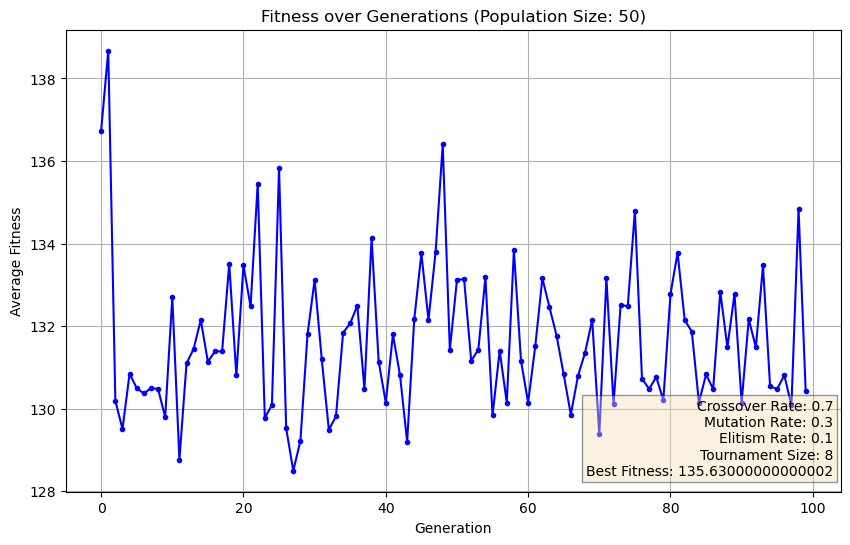

In [1075]:
import time
import matplotlib.pyplot as plt

pop_size=50
max_generations=100
crossover_prob=0.7
mutation_prob=0.3
tournament_size=8
elite_rate=0.1
rounds=50

clock_start = time.time() # start clock

## run genetic_algorithm
best_sol, best_sol_fit, avg_fitness_history, best_hist = genetic_algorithm( pop_size,  max_generations, crossover_prob, mutation_prob,tournament_size,elite_rate,rounds)

clock_end = time.time() # stop clock

print("Computation Time: ",clock_end - clock_start)
print(" ")
print("Best Fitness: ", best_sol_fit)
box_text = f"Crossover Rate: {crossover_prob}\nMutation Rate: {mutation_prob}\nElitism Rate: {elite_rate}\nTournament Size: {tournament_size}\nBest Fitness: {best_sol_fit}"

# Set properties of bounding box
props = dict(boxstyle='square', facecolor='wheat', alpha=0.4)

# Plotting the average fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_fitness_history, marker='.', linestyle='-', color='b')
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title(f"Fitness over Generations (Population Size: {pop_size})")

plt.text(
    0.99, 0.2, 
    box_text, 
    transform=plt.gca().transAxes,
    fontsize=10, 
    verticalalignment='top', 
    horizontalalignment='right', 
    bbox=props
)

plt.grid(True)
plt.show()
